In [52]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
from mpl_finance import candlestick_ochl
import matplotlib.dates as mpl_dates
import chart

# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(url="https://saturn.hasura.app/v1/graphql", headers={'x-hasura-admin-secret': 'Rc07SJt4ryC6RyNXDKFRAtFmRkGBbT8Ez3SdaEYsHQoHemCldvs52Kc803oK8X62'})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

async def get_stored_data(symbol,timeframe):
    # Provide a GraphQL query
    split_symbol=symbol.split('/')
    base_currency=split_symbol[0]
    quote_currency=split_symbol[1]
    table=base_currency+quote_currency+'_'+timeframe
    if table=='BTCUSD_1d':
        query = gql(
            """
            query MyQuery {
                BTCUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHUSD_1d':
        query = gql(
            """
            query MyQuery {
                ETHUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHBTC_1d':
        query = gql(
            """
            query MyQuery {
                ETHBTC_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    else:
        return 'no such table'

    # Execute the query on the transport
    result = await client.execute_async(query)
    candles=result[table]
    df=pd.DataFrame({},columns=['unix','close','high','low','open'])
    for candle in candles:
        df=df.append(candle,ignore_index=True)

    return df.sort_values(by=['unix'], ignore_index=True)

    return result

def find_start(timestamps):
    start_found=False
    timestamps=list(map(lambda x:x[0]/1000,timestamps))
    index=len(timestamps)-1
    while not(start_found):
        print(timestamps[index])
        day=date.fromtimestamp(timestamps[index]).weekday()
        if day==0:
            start_found=True
        else:   
            index=index-1
    return index

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    timestamps=raw['unix']
    for i in range(len(timestamps)):
        if np.log10(timestamps.iloc[i])<12:
            raw.loc[i,'unix']=timestamps[i]*1000
    return raw.sort_values(by=['unix'], ignore_index=True)

# Creating Heikin Ashi candles
First we must download the candlestick data

In [53]:
eth=await get_stored_data('ETH/USD','1d')
weekly_candles=price.get_price_data('1w',data=eth)
weekly_candles

<ipython-input-52-c1a13e0290d5>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(candle,ignore_index=True)
<ipython-input-52-c1a13e0290d5>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(candle,ignore_index=True)
<ipython-input-52-c1a13e0290d5>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(candle,ignore_index=True)
<ipython-input-52-c1a13e0290d5>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(candle,ignore_index=True)
<ipython-input-52-c1a13e0290d5>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

,unix,open,high,low,close
0,1.458432e+12,15.07,15.07,8.338,10.180
1,1.459037e+12,10.18,12.47,10.140,10.400
2,1.459642e+12,10.40,12.30,10.400,11.750
3,1.460246e+12,11.60,11.67,7.520,8.757
4,1.460851e+12,8.56,10.90,6.855,9.455
...,...,...,...,...,...
302,1.641082e+12,4066.20,4128.90,3582.600,3829.200
303,1.641686e+12,3829.20,3896.00,2998.000,3150.800
304,1.642291e+12,3150.80,3413.70,2921.800,3348.300
305,1.642896e+12,3348.30,3359.20,2300.000,2540.500


In [54]:
weekly_candles.iloc[-1][["open","high","low","close"]].values

array([2540.5, 2541. , 2159.5, 2448.7])

Then we define a function to convert each candle stick into Heikin Ashi Candlestick

In [55]:
def heikin_ashi(previous_open, previous_close, candle):
    price_values = candle[["open","high","low","close"]]
    close = np.mean(price_values)
    open_price = 0.5*(previous_open+previous_close)
    high=max([max(price_values), open_price,close])
    low = min([min(price_values), open_price,close])
    
    return candle["unix"], open_price, high, close, low

def convert_data_to_heikin_ashi(data):
    timestamps, opens, closes, highs, lows  = [0], [0],[0],[0],[0]
    #initialise values
    for i in range(1,len(data)):
        timestamp, open_price, high, close, low = heikin_ashi(opens[-1], closes[-1],data.iloc[i])
        timestamps.append(timestamp)
        opens.append(open_price)
        highs.append(high)
        lows.append(low)
        closes.append(close)

    return pd.DataFrame({'unix':timestamps,'open':opens,'high':highs,'low':lows,'close':closes}).sort_values(by=['unix'], ignore_index=True)


Then we convert weekly candles and observe

In [56]:
convert_data_to_heikin_ashi(weekly_candles)

,unix,open,high,low,close
0,0.000000e+00,0.000000,0.000000,0.00000,0.00000
1,1.459037e+12,0.000000,12.470000,0.00000,10.79750
2,1.459642e+12,5.398750,12.300000,5.39875,11.21250
3,1.460246e+12,8.305625,11.670000,7.52000,9.88675
4,1.460851e+12,9.096187,10.900000,6.85500,8.94250
...,...,...,...,...,...
302,1.641082e+12,4031.798491,4128.900000,3582.60000,3901.72500
303,1.641686e+12,3966.761745,3966.761745,2998.00000,3468.50000
304,1.642291e+12,3717.630873,3717.630873,2921.80000,3208.65000
305,1.642896e+12,3463.140436,3463.140436,2300.00000,2887.00000


Shift timestamps up one, delete the top and bottom row (top row is null, bottom row is incomplete). The candle at each timestamp represents the previous week, any data we observe at time=t is from the past. Each bar closes at the it's timestamp

In [57]:
def convert_data_to_heikin_ashi_processed(data):
    timestamps, opens, closes, highs, lows  = [0], [0],[0],[0],[0]
    #initialise values
    for i in range(1,len(data)):
        timestamp, open_price, high, close, low = heikin_ashi(opens[-1], closes[-1],data.iloc[i])
        timestamps.append(timestamp)
        opens.append(open_price)
        highs.append(high)
        lows.append(low)
        closes.append(close)

    candles = pd.DataFrame({'unix':timestamps,'Open':opens,'High':highs,'Low':lows,'Close':closes}).sort_values(by=['unix'], ignore_index=True)
    timestamp_df=candles['unix'].shift(periods=-1)
    candles["unix"] = timestamp_df
    return candles.drop([0,1,len(candles)-1], axis=0)

heikin_ashi_candles = convert_data_to_heikin_ashi_processed(weekly_candles)

Now we plot the heikin ashi candles using the mpl_finance module.

In [68]:
heikin_ashi_candles["Date"] = pd.to_datetime(heikin_ashi_candles["unix"], unit="ms")
heikin_ashi=heikin_ashi_candles.drop(["unix"], axis=1)

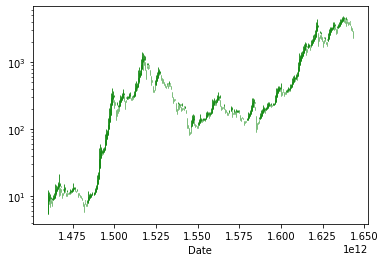

In [69]:
fig, ax = plt.subplots()
heikin_ashi_candles['Date'] = heikin_ashi_candles['Date'].apply(mpl_dates.date2num)
heikin_ashi_candles = heikin_ashi_candles.astype(float)

candlestick_ochl(ax, heikin_ashi_candles.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
ax.set_xlabel("Date")
ax.set_yscale("log")

For each candle calculate the following metrics:
-  Close/low
-  close/high
-  close/open

In [71]:
closes = np.array(heikin_ashi_candles["Close"])
open_prices = np.array(heikin_ashi_candles["Open"])
highs = np.array(heikin_ashi_candles["High"])
lows = np.array(heikin_ashi_candles["Low"])

c_l = np.divide(closes,lows)
c_h = np.divide(closes, highs)
c_o = np.divide(closes, open_prices)